# Face Off

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
import joblib as jb

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as Transforms
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from torch.nn import init

import torch.nn as nn
import torch.nn.functional as F

from modules import Generator, Discriminator
from modules import init_weights_normal, init_weights_xavier

%matplotlib inline

In [2]:
# define hyperparameters
PATH = 'data/'
IMAGE_SIZE = 64
BATCH_SIZE = 16
NUM_WORKERS = 0
EPOCHS = 10
PRINT_EVERY = 200
GPU = torch.cuda.is_available()

# define model hyperparameters
DISCRIMINATOR_DIM = 32
GENERATOR_DIM = 64
Z_SIZE = 128 
SAMPLE_SIZE = BATCH_SIZE

## Define DataLoader 
### Image Processing Pipeline
* Resize image
* Convert to Tensor
* Normalize pixel values between -1 and 1

In [3]:
# define transforms pipeline
transforms = Compose([
    Transforms.Resize(IMAGE_SIZE),
    Transforms.ToTensor(),
    Transforms.Normalize(mean=[0.5, 0.5, 0.5], # scales pixel values between -1 and 1
                         std=[0.5, 0.5, 0.5]) 
])

# load locally saved images
image_folder = ImageFolder(PATH, transforms)

# create data loader
real_image_loader = DataLoader(image_folder, BATCH_SIZE, True,  num_workers=NUM_WORKERS)

In [4]:
def display_image(image_tensor):
    '''
    Converts an image tesnor to an equivalent sized numpy array image 
    inputs:
        image_tensor: PyTroch Tensor
    '''
    # convert tensor to numpy array
    img = image_tensor.numpy()
    
    # change color dimensions to RGB
    img = np.transpose(img, (1, 2, 0))
    
    return img

## Visualize a Batch of Images (Sanity Check)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

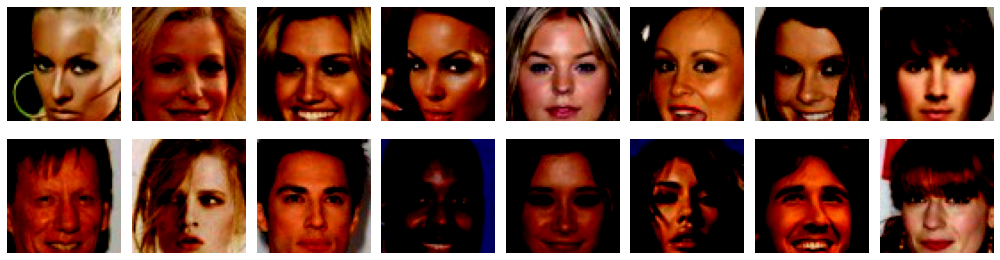

In [5]:
# define figure with the same amount of plots as the batch size
FIGSIZE = (14, 12)
fig, axes = plt.subplots(2, BATCH_SIZE//2, figsize=FIGSIZE)
axes = axes.ravel() # allow iteration

# yield a batch of images
images_to_visualize, _ = next(iter(real_image_loader))

for ax, tensor_image in zip(axes, images_to_visualize):
    
    image = display_image(tensor_image)
    ax.imshow(image)
    ax.set_axis_off()
    
plt.subplots_adjust(wspace=0, hspace=-1.05)
plt.tight_layout()

To train speed up model training, I used reduced size images (64 by 64 pixels).

## Define the Generative Model 

    1. Discriminator
    2. Generator
    
### Weight Initaliztion 

* Initalizing the Discriminator weights to a normal distribution centered around 0 with a std of 0.02.
* Initalizing the Generator weights to a Xavier's distribution centered around 0 with a std of 0.02.

### Discriminator

In [9]:
# instanciate discriminator and initalize weights
D = Discriminator(DISCRIMINATOR_DIM)
D.apply(init_weights_normal)

# validate discriminator architecture
print(D)

Discriminator(
  (input): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
  )
  (outputs): Linear(in_features=8192, out_features=1, bias=True)
)


In [6]:
# test the Discriminator class
tests.test_discriminator(Discriminator)

Tests Passed


### Generator

In [10]:
# instanciate generator
G = Generator(Z_SIZE, GENERATOR_DIM)
G.apply(init_weights_xavier)

# validate generator architecture
print(G)

Generator(
  (input): Linear(in_features=128, out_features=16384, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (outputs): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [7]:
# test the Generator class
tests.test_generator(Generator)

Tests Passed


### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 

### Generator Loss

> * The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

In [ ]:
def real_image_loss(outputs, batch_size, gpu=False, smoothing=False):
    '''
    Calculates how close discriminator outputs are to being real and return the "real" loss.
    inputs:
        outputs: discriminator logits
        batch_size: int, batch_size
        gpu: bool, train on gpu or not (defualt=False)
        smoothing: bool, prevents the discriminator overfitting to the real images (defualt=False)
    '''
    
    # smoothing prevents the discriminator overfitting to the real images
    labels = torch.ones(batch_size) * 0.9 if smoothing else torch.ones(batch_size)
    
    # move labels to gpu if found
    if gpu:
        labels = labels.cuda()
        
    # BCEWLL
    criterion = nn.BCEWithLogitsLoss()
    
    # eliminate batch size and compute the loss
    return criterion(outputs.squeeze(), labels)

def fake_image_loss(outputs, batch_size, gpu=False):
    '''
    Calculates how close discriminator outputs are to being fake and return the "fake" loss
    input:
        discriminator_output: discriminator logits
        batch_size: int, batch_size
        gpu: bool, train on gpu or not (defualt=False)
    '''
    
    # fake image labels
    labels = torch.zeros(batch_size)
    
    # move labels to gpu if found
    if gpu:
        labels = labels.cuda()
        
    # BCEWLL
    criterion = nn.BCEWithLogitsLoss()
    
    # eliminate batch size and compute the loss
    return criterion(outputs.squeeze(), labels)

## Optimizers

Define optimizers for your models with appropriate hyperparameters.

In [ ]:
import torch.optim as optim

b1 = 0.5
b2 = 0.999 

# Create optimizers for the discriminator D and generator G
discriminator_optim = optim.Adam(D.parameters(), lr=5e-5, betas=(b1, b2)) # used in the DCGAN paper
generator_optim = optim.Adam(G.parameters(), lr=5e-5, betas=(b1, b2)) # used in the DCGAN paper

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [ ]:
def train_discriminator(discriminator, optimizer, inputs, gpu, batch_size, real=True, generator=None):
    '''
    
    '''
    if real:
        discriminator_output = discriminator(inputs)
        discriminator_loss = real_loss(discriminator_output, batch_size, gpu, smoothing=True)
        
    else:
        # generate fake images
        fake_images = generator(inputs) 
        
        # train on fake images
        discriminator_output = discriminator(fake_images)
        discriminator_loss = fake_loss(discriminator_output, batch_size, gpu)
        
    return discriminator_loss

def train_generator(generator, discriminator, optimizer, inputs, gpu, batch_size):
    '''
    
    '''
    # generate fake images
    fake_images = generator(inputs) 

    # train on fake images
    generator_output = discriminator(fake_images)
    generator_loss = real_loss(generator_output, batch_size, gpu, smoothing=False)
    
    return generator_loss
    
    
def generate_sample_images(sample_size, z_size):
    '''
    
    '''
    # get some fixed data for sampling. these are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample = np.random.uniform(-1, 1, size=(sample_size, z_size))
    sample = torch.from_numpy(sample).float()
    
    return sample

In [ ]:
total_loss = []

if GPU:
    D.cuda()
    G.cuda()
    
for epoch in range(2):
    for n, (real_images, _) in enumerate(real_image_loader):
        
        # training mode
        G.train() 
        D.train() 
        
        # TRAIN DISCRIMINATOR
        
        # clear gradients
        discriminator_optim.zero_grad()
        
        # train the discriminator on real images
        if GPU:
            real_images = real_images.cuda()
        
        discriminator_real_image_loss = train_discriminator(D, discriminator_optim, 
                                                            real_images, GPU, BATCH_SIZE)
        
        
        # train the discriminator on fake images
        fakes = generate_sample_images(BATCH_SIZE, Z_SIZE)
        
        if GPU:
            fakes = fakes.cuda()
            
        discriminator_fake_image_loss = train_discriminator(D, discriminator_optim, 
                                                            fakes, GPU, BATCH_SIZE,
                                                            real=False, generator=G)
        
        # compute discriminator total loss and perform backprop
        discriminator_loss = discriminator_real_image_loss + discriminator_fake_image_loss
        discriminator_loss.backward()
        discriminator_optim.step()
        
        # TRAIN GENERATOR 
        
        # clear gradients
        generator_optim.zero_grad()
        
        # train the generator on adverserial loss
        fakes = generate_sample_images(BATCH_SIZE, Z_SIZE)
        
        if GPU:
            fakes = fakes.cuda()
            
        # compute generator loss
        generator_loss = train_generator(G, D, generator_optim, fakes, GPU, BATCH_SIZE)
        generator_loss.backward()
        generator_optim.step()
        
        
        # print some loss stats
        if n % PRINT_EVERY == 0:
            
            # note loss
            total_loss.append((discriminator_loss.item(), generator_loss.item()))
            
            # print discriminator and generator loss
            print(f'Epoch: {epoch+1}/{EPOCHS} || D Loss: {discriminator_loss} || G Loss: {generator_loss}')
            print(fakes[0].size())
        # save model weights
                
            
# clear GPU memory
if GPU:
    D.cpu()
    G.cpu()
    real_images = real_images.cpu()
    fakes = fakes.cpu()

In [ ]:
# evaluate geneerator performance    

G.eval() 
with torch.no_grad():
    constant_sample = generate_sample_images(SAMPLE_SIZE, Z_SIZE)
    samples_z = G(constant_sample)
    
# view samples

In [ ]:
def train(D, G, n_epochs, train_on_gpu, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(real_image_loader):

            batch_size = real_images.size(0)
            #real_images = scale(real_images)
            
            # DISCRIMINATOR TRAIN
            d_optimizer.zero_grad()
            
            # 1.1 Train the discriminator on real images
            real_images = real_images.cuda() if train_on_gpu else real_images
            disc_real_train = D(real_images)
            d_real_loss = real_loss(disc_real_train, batch_size, train_on_gpu, smoothing=True)
            
            # 1.2 Train the discriminator on fake images
            fake_arr = np.random.uniform(-1, 1, size=(batch_size, z_size))
            fake_arr = torch.from_numpy(fake_arr).float()
            fake_arr = fake_arr.cuda() if train_on_gpu else fake_arr
            fake_image = G(fake_arr) 
            
            disc_fake_train = D(fake_image)
            d_fake_loss = fake_loss(disc_fake_train, batch_size, train_on_gpu)
            
            # compute discriminator total loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            # GENERATOR TRAIN
            g_optimizer.zero_grad()
            
            # 2. Train the generator with an adversarial loss
            fake_arr = np.random.uniform(-1, 1, size=(batch_size, z_size))
            fake_arr = torch.from_numpy(fake_arr).float()
            fake_arr = fake_arr.cuda() if train_on_gpu else fake_arr
            fake_image = G(fake_arr) 
            
            # compute loss on fake images and real images label
            disc_fake_train = D(fake_image)
            
            # compute generator loss and perform backprop
            g_loss = real_loss(disc_fake_train, batch_size, train_on_gpu, smoothing=False)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # unload gpu memory
    if train_on_gpu:
        D.cpu()
        G.cpu()
        real_images = real_images.cpu()
        fake_image = fake_image.cpu()
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [ ]:
# set number of epochs 
n_epochs = 15

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs, train_on_gpu, print_every=150)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64,3)))
        
    plt.show()

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples, and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result

Question: What do you notice about your generated samples, and how might you improve this model?
Not surprisingly, the model creates low-resolution images. Nevertheless, the generated samples look decent (granted, some of them seem like Frankenstein). Unfortunately, more extended training doesn't improve the pictures. There are 32k images in our dataset. This number is several orders of magnitudes smaller than the number of people that exist (or existed). Because people of color weren't well represented, I expected to generate more realistic-looking faces with light-colored complexion. Also, I suspect that the model would not create as many faces with colors.

To improve the generative model, I would probably need to restrain the discriminator even more than I have. So, I started with a 0.9 smoothing factor and lowered it to 0.75. Furthermore, I noticed that the discriminator learns a lot faster than the generator and that training the model for more time did not improve the results. 

To prevent the discriminator from overfitting and improve the generative model outputs, I would:

1. Remove one of the convolutional layers.
2. Add noise to the authentic images. I would likely try to implement a "noise decay" strategy. Meaning, I would add more noise to the pictures at the beginning of the training and reduce the amount of noise as the training process continues.

Additionally, I would try changing the generator's weight initialization strategy to Xavier's initialization. I read online it yielded better results than the normal distribution strategy when using the tanh activation function.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.